In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [4]:
from datasets import load_dataset

dataset = load_dataset("xtreme", name="PAN-X.te")

In [5]:
from collections import defaultdict
from datasets import DatasetDict 

langs = ["hi", "te", "ta", "en"]
fracs = [0.5709, 0.0777, 0.6360, 0.1067]
fracs = [frac / sum(fracs) for frac in fracs]
# return a DatasetDict if a key does not exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # load multilingual corpus 
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=42)
            .select(range(int(frac * ds[split].num_rows)))
        )

In [6]:
import pandas as pd 

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, 
             index=["Number of training examples"])

,hi,te,ta,en
Number of training examples,2051,55,6856,1533


In [7]:
element = panx_ch["hi"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['प्रेम', 'चोपड़ा', '-', 'गिरिधारीलाल']
ner_tags: [1, 2, 0, 0]
langs: ['hi', 'hi', 'hi', 'hi']


In [8]:
for key, value in panx_ch["hi"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
tags = panx_ch["hi"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [10]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_hi = panx_ch["hi"].map(create_tag_names)

In [11]:
hi_example = panx_hi["train"][0]
pd.DataFrame([hi_example["tokens"], hi_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3
Tokens,प्रेम,चोपड़ा,-,गिरिधारीलाल
Tags,B-PER,I-PER,O,O


In [12]:
from collections import Counter 

split2freqs = defaultdict(Counter)
for split, dataset in panx_hi.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1 

pd.DataFrame.from_dict(split2freqs, orient="index")

,PER,ORG,LOC
train,945,753,790
validation,177,140,185
test,158,151,176


Multilingual transformers

In [13]:
from transformers import AutoTokenizer 

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [14]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [15]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [16]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [17]:
# whitespace is preserved by using xlmr which uses the SentencePiece tokenizer
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## Transformers for Named Entity Recognition

In [18]:
import torch.nn as nn 
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [19]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super(XLMRobertaForTokenClassification, self).__init__(config)
        self.num_labels = config.num_labels
        # load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # set up token classification head 
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # load and initialize weights 
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        # apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # calculate losses 
        loss = None 
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # return model output object 
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )



## Loading a Custom Model

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [22]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

In [23]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# test on a small sequence of known entities 
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [25]:
outputs = xlmr_model(input_ids.to(device)).logits 
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(F"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [26]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG


In [27]:
def tag_text(text, tags, model, tokenizer):
    # get tokens with special characters
    tokens = tokenizer(text).tokens()
    # encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # get predictions as a distribution over 7 possible classes 
    outputs = model(input_ids)[0]
    # take argmax to get most likely class per token 
    predictions = torch.argmax(outputs, dim=2)
    # convert to dataframe
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## Tokenizing Texts for NER

In [28]:
words, labels = hi_example["tokens"], hi_example["ner_tags"]

In [29]:
tokenized_input = xlmr_tokenizer(hi_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7
Tokens,<s>,▁प्रेम,▁चोपड़ा,▁-,▁गिरि,धारी,लाल,</s>


In [30]:
# need to mask the subwords after the first subword
word_ids = tokenized_input.word_ids() 
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7
Tokens,<s>,▁प्रेम,▁चोपड़ा,▁-,▁गिरि,धारी,लाल,</s>
Word IDs,None,0,1,2,3,3,3,None


In [31]:
previous_word_idx = None 
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in labels]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7
Tokens,<s>,▁प्रेम,▁चोपड़ा,▁-,▁गिरि,धारी,लाल,</s>
Word IDs,None,0,1,2,3,3,3,None
Label IDs,-100,1,2,0,0,-100,-100,-100
Labels,B-PER,I-PER,O,O,None,None,None,None


In [32]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = [] 
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None 
        label_ids = [] 
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels 
    return tokenized_inputs

In [33]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

panx_hi_encoded = encode_panx_dataset(panx_ch["hi"])

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

In [34]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [35]:
import numpy as np 

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], [] 

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], [] 
        for seq_idx in range(seq_len):
            # ignore label ids = -100 
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

    

## Fine-tuning XLM-RoBERTa

In [36]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_hi_encoded["train"]) // batch_size 
model_name = f"{xlmr_model_name}-finetuned-panx-hi"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True
)

In [37]:
from huggingface_hub import notebook_login 

notebook_login()

In [38]:
from seqeval.metrics import f1_score 

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [39]:
from transformers import DataCollatorForTokenClassification 

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [40]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [41]:

from transformers import Trainer 

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
                   train_dataset=panx_hi_encoded["train"], eval_dataset=panx_hi_encoded["validation"], tokenizer=xlmr_tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [42]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.840400,0.412699,0.718690
2,0.351300,0.337911,0.772507
3,0.234100,0.284781,0.824338


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi
   f022602..09586e2  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi
   09586e2..5ce7b8e  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi/commit/09586e26dd7362ff4a1437703e88e2e4edd41162'

In [43]:
text_hi = "तेजी बच्चन से अमिताभ तथा अजिताभ दो पुत्र हुए ।"
tag_text(text_hi, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁तेजी,▁बच्चन,▁से,▁अमिताभ,▁तथा,▁अज,िता,भ,▁दो,▁पुत्र,▁हुए,▁।,</s>
Tags,O,B-PER,I-PER,O,B-PER,O,B-PER,I-PER,I-PER,O,O,O,O,O


## Error Analysis

In [44]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # convert dict of lists of list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size [batch_size, sequence_length, classes]
        # predict class with largest logit value on classes axis 
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy() 
    
    # calculate loss per token after flattening batch dimension with view 
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none") 
    # unflatten batch dimension and convert to numpy array 
    loss = loss.view(len(input_ids), -1).cpu().numpy() 
    
    return {'loss': loss, 'predicted_label': predicted_label}

In [45]:
valid_set = panx_hi_encoded["validation"] 
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

In [46]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]) 
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 2218, 14136, 5988, 67691, 460, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.031384714, 0.0, 0.03725087, 0.03313421...","[I-LOC, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-LOC]","[<s>, ▁स, जन, ▁घर, ▁जाना, ▁है, </s>]"
1,"[0, 93019, 7475, 976, 156711, 41612, 3558, 967...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, IGN, IGN, IGN, B-PER, IGN, IGN, IGN, ...","[0.0, 0.002951078, 0.0, 0.0, 0.0, 0.010400972,...","[O, O, O, O, O, B-PER, B-PER, I-PER, B-PER, I-...","[<s>, ▁पुनर्, प्र, े, षित, ▁फ़, ि, रो, ज़, ▁शा..."
2,"[0, 11026, 3849, 8389, 1471, 871, 76302, 659, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, IGN, I-LOC, I-LOC, IGN,...","[0.0, 0.01155906, 0.0, 0.0, 0.0, 0.01743069, 0...","[I-LOC, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-L...","[<s>, ▁ला, ह, ौ, ल, ▁और, ▁स्प, ी, ति, ▁जिला, <..."
3,"[0, 20571, 3282, 6, 150685, 20, 3813, 1187, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, IGN, I-PER, IGN, O, O, IGN, IGN, ...","[0.0, 0.010598798, 0.0, 0.012605397, 0.0, 0.00...","[O, B-PER, I-PER, I-PER, I-PER, O, O, O, O, O]","[<s>, ▁अस, ित, ▁, सेन, ▁-, ▁था, ने, दार, </s>]"
4,"[0, 9163, 2629, 76183, 1472, 6, 4, 46005, 1187...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, IGN, I-LOC, IGN, I-LOC,...","[0.0, 0.071242474, 0.0, 0.0, 0.0, 0.5964037, 0...","[I-LOC, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-L...","[<s>, ▁मे, म्, फि, स, ▁, ,, ▁टे, ने, सी, </s>]"


In [47]:
df_tokens = df.apply(pd.Series.explode) 
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2) 
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,2218,1,B-ORG,0.03,B-ORG,▁स
0,5988,1,I-ORG,0.04,I-ORG,▁घर
0,67691,1,I-ORG,0.03,I-ORG,▁जाना
0,460,1,I-ORG,0.03,I-ORG,▁है
1,93019,1,O,0.00,O,▁पुनर्
1,41612,1,B-PER,0.01,B-PER,▁फ़
1,51757,1,I-PER,0.02,I-PER,▁शाह


In [48]:
(df_tokens.groupby("input_tokens")[["loss"]]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="sum", ascending=False)
 .reset_index()
 .round(2)
 .head(10)
 .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁),▁(,▁का,▁सी,▁राज्य,▁N,▁डी,▁र,▁क्रिकेट
count,235,80,80,39,7,9,1,6,13,4
mean,0.34,0.47,0.42,0.37,1.49,0.91,7.91,1.28,0.59,1.83
sum,79.36,37.8,33.38,14.41,10.44,8.16,7.91,7.68,7.63,7.32


In [49]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-ORG,I-LOC,O,B-LOC,B-ORG,I-PER,B-PER
count,407,163,976,185,140,259,177
mean,0.38,0.71,0.12,0.41,0.52,0.28,0.26
sum,153.78,116.0,113.91,76.5,72.75,71.89,45.95


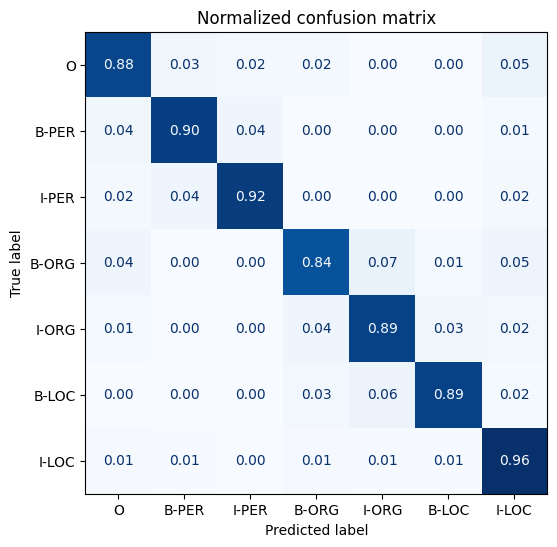

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show() 
    
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [51]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], [] 
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels":labels, "preds": preds, "losses": losses}).T

        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6
tokens,▁चिन,▁राज्य,▁(,▁प्राचीन,▁चीन,▁),</s>
labels,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,3.97,5.40,5.00,4.90,5.36,4.88,0.00


,0,1,2,3,4,5,6,7
tokens,▁एन,एस,ई,▁(,▁N,SE,▁),</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,IGN,I-ORG,IGN
preds,O,O,O,O,O,O,O,O
losses,1.66,0.00,0.00,6.98,7.91,0.00,7.10,0.00


,0,1,2,3,4,5,6,7,8,9,10
tokens,▁मु,ग,़,ल,▁बाद,शा,ह,ों,▁की,▁सूची,</s>
labels,B-PER,IGN,IGN,IGN,I-PER,IGN,IGN,IGN,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.80,0.00,0.00,0.00,4.82,0.00,0.00,0.00,5.31,5.51,0.00


In [52]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample) 

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,▁मिल,ो,रा,ड,▁म,ज़,िक,▁(,▁सर्,बिया,▁),</s>
labels,O,IGN,IGN,IGN,O,IGN,IGN,O,B-LOC,IGN,O,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O,B-LOC,I-LOC,O,O
losses,1.38,0.00,0.00,0.00,1.78,0.00,0.00,0.03,0.05,0.00,0.12,0.00


,0,1,2,3,4,5,6,7,8,9
tokens,▁राजेन्द्र,▁सिंह,▁(,▁र,ज्,जू,▁भै,या,▁),</s>
labels,B-PER,I-PER,I-PER,I-PER,IGN,IGN,I-PER,IGN,I-PER,IGN
preds,B-PER,I-PER,O,O,O,I-PER,I-PER,I-PER,O,O
losses,0.02,0.01,2.00,3.40,0.00,0.00,0.27,0.00,1.30,0.00


## Cross Lingual Transfer

In [53]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [54]:
f1_scores = defaultdict(dict)
f1_scores["hi"]["hi"] = get_f1_score(trainer, panx_hi_encoded["test"])
print(f"F1-score of [hi] model on [hi] dataset: {f1_scores['hi']['hi']:.3f}")

F1-score of [hi] model on [hi] dataset: 0.798


In [55]:
text_te = "నా అమ్మ కళ్లకు నీళ్ళు పోయాయి"
tag_text(text_te, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10
Tokens,<s>,▁నా,▁అమ్మ,▁క,ళ్ల,కు,▁నీ,ళ్ళు,▁,పోయాయి,</s>
Tags,O,B-PER,I-PER,I-ORG,I-ORG,O,I-ORG,I-ORG,O,O,O


In [56]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [57]:
f1_scores["hi"]["te"] = evaluate_lang_performance("te", trainer)
f1_scores["hi"]["ta"] = evaluate_lang_performance("ta", trainer)
f1_scores["hi"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [hi] model pn [te] dataset: {f1_scores['hi']['te']:.3f}")
print(f"F1-score of [hi] model pn [ta] dataset: {f1_scores['hi']['ta']:.3f}")
print(f"F1-score of [hi] model pn [en] dataset: {f1_scores['hi']['en']:.3f}")

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Map:   0%|          | 0/6856 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1533 [00:00<?, ? examples/s]

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

F1-score of [hi] model pn [te] dataset: 0.525
F1-score of [hi] model pn [ta] dataset: 0.552
F1-score of [hi] model pn [en] dataset: 0.529


In [58]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples)) 
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size 
    
    trainer = Trainer(model_init=model_init, args=training_args,
                      data_collator=data_collator, compute_metrics=compute_metrics,
                      train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train() 
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!") 
        
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [59]:
panx_ta_encoded = encode_panx_dataset(panx_ch["ta"])
training_args.push_to_hub = False 
metrics_df = train_on_subset(panx_ta_encoded, 250)
metrics_df

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.738000,1.143364,0.000000
2,1.189500,0.940089,0.109989
3,1.058700,0.853741,0.205519


,num_samples,f1_score
0,250,0.182665


In [60]:
for num_samples in [500, 1000, 2000, 4000]:
    result = train_on_subset(panx_ta_encoded, num_samples)
    metrics_df = pd.concat([metrics_df, result], ignore_index=True)

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.458700,0.895834,0.156504
2,0.801100,0.639908,0.489311
3,0.616900,0.560348,0.525695


Epoch,Training Loss,Validation Loss,F1
1,1.149500,0.605709,0.445705
2,0.476500,0.413904,0.620573
3,0.333000,0.380578,0.683262


Epoch,Training Loss,Validation Loss,F1
1,0.823300,0.378921,0.660228
2,0.335100,0.300935,0.726016
3,0.226900,0.299077,0.750000


Epoch,Training Loss,Validation Loss,F1
1,0.580900,0.297101,0.725979
2,0.264100,0.239029,0.749110
3,0.177300,0.240749,0.776014


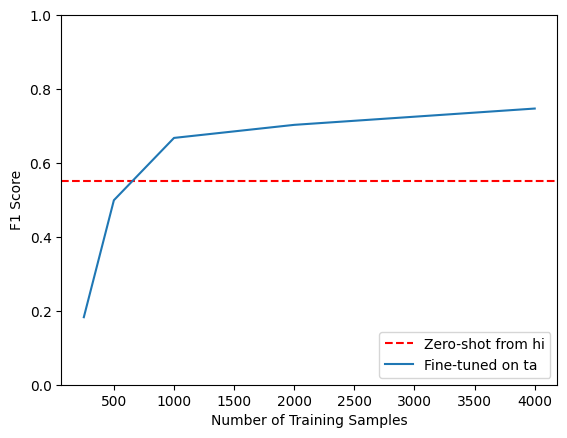

In [61]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["hi"]["ta"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax) 
plt.legend(["Zero-shot from hi", "Fine-tuned on ta"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

## Fine-Tuning on Multiple Languages at Once

In [62]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus 

In [63]:
panx_hi_ta_encoded = concatenate_splits([panx_hi_encoded, panx_ta_encoded])

In [64]:
training_args.logging_steps = len(panx_hi_ta_encoded["train"]) // batch_size 
training_args.push_to_hub = True 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-hi-ta"

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics, 
                  tokenizer=xlmr_tokenizer, train_dataset=panx_hi_ta_encoded["train"],
                  eval_dataset=panx_hi_ta_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi-ta into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.486300,0.286928,0.764870
2,0.229700,0.228381,0.814884
3,0.152700,0.219733,0.841515


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi-ta
   1f4bcce..ee5064e  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi-ta
   ee5064e..18f9a46  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-hi-ta/commit/ee5064e5c1507fc85048d794b3dbba4d2a5f0895'

In [65]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [hi-fa] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/2051 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

F1-score of [hi-fa] model on [hi] dataset: 0.823


Map:   0%|          | 0/55 [00:00<?, ? examples/s]

F1-score of [hi-fa] model on [te] dataset: 0.543


F1-score of [hi-fa] model on [ta] dataset: 0.820


F1-score of [hi-fa] model on [en] dataset: 0.444


In [66]:
corpora = [panx_hi_encoded] 

# exclude hindi from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # fine-tune on monolingual corpus 
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # collect F1-scores in common dict 
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-te into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,2.392800,1.836161,0.066667
2,1.372800,1.059116,0.000000
3,1.208100,1.005862,0.000000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-te
   4bc9a2f..cf8016b  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-te
   cf8016b..99b3b19  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-ta into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.484300,0.253147,0.765018
2,0.227100,0.226759,0.786340
3,0.152400,0.232035,0.803556


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-ta
   ebac8f4..e0ad97a  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-ta
   e0ad97a..3315405  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible


Cloning https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-en into local empty directory.


	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.967500,0.457414,0.593826
2,0.430200,0.407517,0.662712
3,0.309000,0.381227,0.700170


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-en
   a0a1364..773c984  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-en
   773c984..7b5883b  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [67]:
corpora_encoded = concatenate_splits(corpora)

In [68]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-all into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/data/ssd2/abhiroop/misc/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.486400,0.381709,0.698385
2,0.241900,0.305041,0.765427
3,0.160600,0.302310,0.794586


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-all
   adbb237..ab4985f  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-all
   ab4985f..e6d5947  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/the-neural-networker/xlm-roberta-base-finetuned-panx-all/commit/ab4985f7081e59d04b156e81f515f2ed40a854fd'

In [69]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data = {"hi": f1_scores["hi"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on", 
                         inplace=True)
f1_scores_df

Evaluated on,hi,te,ta,en
Fine-tune on,,,,
hi,0.7984,0.5248,0.5517,0.5289
each,0.7984,0.0000,0.8069,0.7154
all,0.8176,0.6043,0.8000,0.7467
